In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import math
import string

In [2]:
pd.options.mode.copy_on_write = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["figure.autolayout"] = True

In [3]:
def load_wang_pi_data():
    df = pd.read_excel("./data/wang_raw_data_mutation_rate_literature_updating3.xlsx", sheet_name="gs_gt", 
                       header=0, usecols="A,E")
    df = df.rename(columns={"Species": "species"}) 
    df["species"] = df["species"].str.lower()
    return df

In [4]:
def load_bergeron_mut_rate_data():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 9", 
                       header=1, usecols="A,C,D,J,R,S", skiprows=0)
    df = df.rename(columns={
        "Species name": "species", 
        "Taxonomic group": "group",
        "Taxonomic order": "order",
        "Generation time (years)": "gen_time",
        "Average yearly mutation rate (m_yearly)": "u_year_non_modeled",
        "Modeled rate per generation (m_generation_modeled)": "u_modeled"})
    df["u_gen_non_modeled"] = df["gen_time"] * df["u_year_non_modeled"]
    primate_idx = (df["order"] == "Primate")
    df.loc[primate_idx, "group"] = "Primate"
    df = df.drop('order', axis=1)
    return df
    
def load_bergeron_CpG_frac_data():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 4", 
                       header=1, usecols="A,C:M", skiprows=0)
    # sum up column 2 to 11 (exclusive) to get total mutation count
    df["mutation count"] = df.iloc[:,2:11].sum(axis=1)
    df["perc_CpG>TpG"] = (df["% of all mutation in CpG"]/100) * (df["% of C > T in CpG"]/100) * 100
    df = df.rename(columns={"Species": "species"})
    df = df[["species", "perc_CpG>TpG", "mutation count"]]
    # drop last row because it is the total sum of mutations across all species
    df.drop(df.tail(1).index,inplace=True)
    df.loc[df["species"] == "Sphaerodactylus_macrolepis", "species"] = "Sphaerodactylus_inigoi"
    return df

def merge_bergeron_dfs():
    df_mu = load_bergeron_mut_rate_data()
    df_CpG = load_bergeron_CpG_frac_data()
    df_merge = pd.merge(df_CpG, df_mu, on=["species"])
    df_merge["u_CpG_gen_non_modeled"] = df_merge["u_gen_non_modeled"] * df_merge["perc_CpG>TpG"] / 100
    df_merge["u_CpG_year_non_modeled"] = df_merge["u_year_non_modeled"] * df_merge["perc_CpG>TpG"] / 100
    assert len(df_mu) == len(df_CpG) and len(df_mu) == len(df_merge)
    print(f"In total {len(df_merge)} species in Bergeron's dataset with mutation rate estimates, {df_merge['u_modeled'].isna().sum()} does not have a modeled per-generation mutation rate")
    df_merge["species"] = df_merge["species"].str.lower()
    return df_merge

def convert_wang_df_species_name(df):
    # Wang's species name are not delimited by '_'
    df["species"] = df.apply(lambda x: "_".join(x["species"].split(" ")), axis=1)
    # 2 species name have a mismatch
    w2b_map = {
        'gallus_gallus_domesticus': 'gallus_gallus', 
        'tupaia_chinensis_belangeri': 'tupaia_belangeri'
    }
    df = df.replace({"species": w2b_map})
    return df
    
def check_bergeron_wang_species(df_b, df_w):
    '''helper function to check that the species names in bergeron's dataset match that of wang's'''
    species_b = set(df_b["species"])
    species_w = set(df_w["species"])
    assert len(species_b - species_w) == 0
    
def merge_wang_bergeron_dfs():
    df_b = merge_bergeron_dfs()
    df_w = load_wang_pi_data()
    df_w_species_update = convert_wang_df_species_name(df_w)
    check_bergeron_wang_species(df_b, df_w_species_update)
    print(df_b.columns, df_w.columns)
    df_merge = pd.merge(df_b, df_w_species_update, on=["species"])
    assert len(df_merge) == len(df_b)
    print(f"After merging Wang and Bergeron's dataset, there are {len(df_merge)} species")
    return df_merge

def calculate_Ne(df):
    """
        this helper function first filters out species with 0 diveristy, 
        and then calculates the Ne using Ne = pi/(4 * mu)
    """
    # num_zero_diversity = np.count_nonzero(df_merge["diversity"] == 0)
    # species_zero_diversity = set(df_merge.loc[(df_merge['diversity'] == 0)]["species"])
    df_div = df[df['diversity'] != 0]
    print(f"after filtering out species with 0 diversity, there are now {len(df_div)} species")
    df_div["Ne"] = df_div["diversity"] / (4 * df_div["u_gen_non_modeled"])
    df_div["Ne*g"] = df_div["Ne"] * df_div["gen_time"]
    return df_div

In [5]:
df_merge = merge_wang_bergeron_dfs()
df_merge.to_csv("./output/csv/df_bergeron_no_ne.csv")
df_div = calculate_Ne(df_merge)
df_div.to_csv("./output/csv/df_bergeron_ne.csv")

In total 68 species in Bergeron's dataset with mutation rate estimates, 13 does not have a modeled per-generation mutation rate
Index(['species', 'perc_CpG>TpG', 'mutation count', 'group', 'gen_time',
       'u_year_non_modeled', 'u_modeled', 'u_gen_non_modeled',
       'u_CpG_gen_non_modeled', 'u_CpG_year_non_modeled'],
      dtype='object') Index(['species', 'diversity'], dtype='object')
After merging Wang and Bergeron's dataset, there are 68 species
after filtering out species with 0 diversity, there are now 62 species


In [6]:
def plot_color_gradients(cmap_name, ax):
    """helper function, given a cmap name, visualize its color gradient"""
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    ax.imshow(gradient, aspect='auto', cmap=matplotlib.colormaps[cmap_name])
    ax.set_axis_off()

def get_color_index(num_groups, group_name_index):
    """Calculate an decimal index between (0.05, 1)"""
    return 1 - (0.05+ (1-0.05) / num_groups * group_name_index)

def plot_regression(df, group_name2idx_map, colors, x_df_key, y_df_key, x_ax_label, y_ax_label, ax=None, label_fontsize=15):
    """
        helper function to generate relevant regression plots, 
        x_df_key: key of the dataframe column plotted on the x-axis (typically Ne or Ne * g),
        y_df_key: key of the dataframe column plotted on the y-axis (typically per-gen or per-year mutation rate), 
        x_ax_label: label on the x-axis
        y_ax_label: label on the y-axis
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    # due to renaming to stay consistent with phylogenetic tree
    df_human = df.loc[df.index[df["species"] == "homo_sapiens"]]
    human_ne, human_mu = df_human[x_df_key].to_numpy()[0], df_human[y_df_key].to_numpy()[0]
    df_mice = df.loc[df.index[df["species"] == "mus_musculus"]]
    mice_ne, mice_mu = df_mice[x_df_key].to_numpy()[0], df_mice[y_df_key].to_numpy()[0]
    ax.scatter(human_ne, human_mu, color=colors[group_name2idx_map["Primate"]], 
               marker='D', edgecolor="black", s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mice_ne, mice_mu, color=colors[group_name2idx_map["Mammal"]], 
               marker='D', edgecolor="blue", s=100, lw=2, zorder=float("inf")) #label="mice"
    offset_factor=1.1
    ax.text(offset_factor * human_ne, offset_factor * human_mu, "human", zorder=float("inf"), fontsize=15)
    ax.text(offset_factor * mice_ne, offset_factor * mice_mu, "mouse", zorder=float("inf"), fontsize=15)

    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group"] == gn]]
        ax.scatter(df_gn[x_df_key], df_gn[y_df_key], color=colors[idx], label=gn)
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_xlabel(x_ax_label, fontsize=label_fontsize, weight="bold")
    ax.set_ylabel(y_ax_label, fontsize=label_fontsize, weight="bold")
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    
    # grid line
    ax.grid(which="major", linestyle = "dashed")
    ax.set_axisbelow(True)

In [7]:
color_map_name = "nipy_spectral"
cmap = matplotlib.colormaps[color_map_name]  
vertebrate_group_name2idx_map = {
    "Primate": 0, 
    "Mammal": 1, 
    "Bird": 2,
    "Reptile": 3,
    "Fish": 4
} 

num_groups = len(vertebrate_group_name2idx_map)
colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]

## DBH plots for overall mutation rate with Bergeron's data

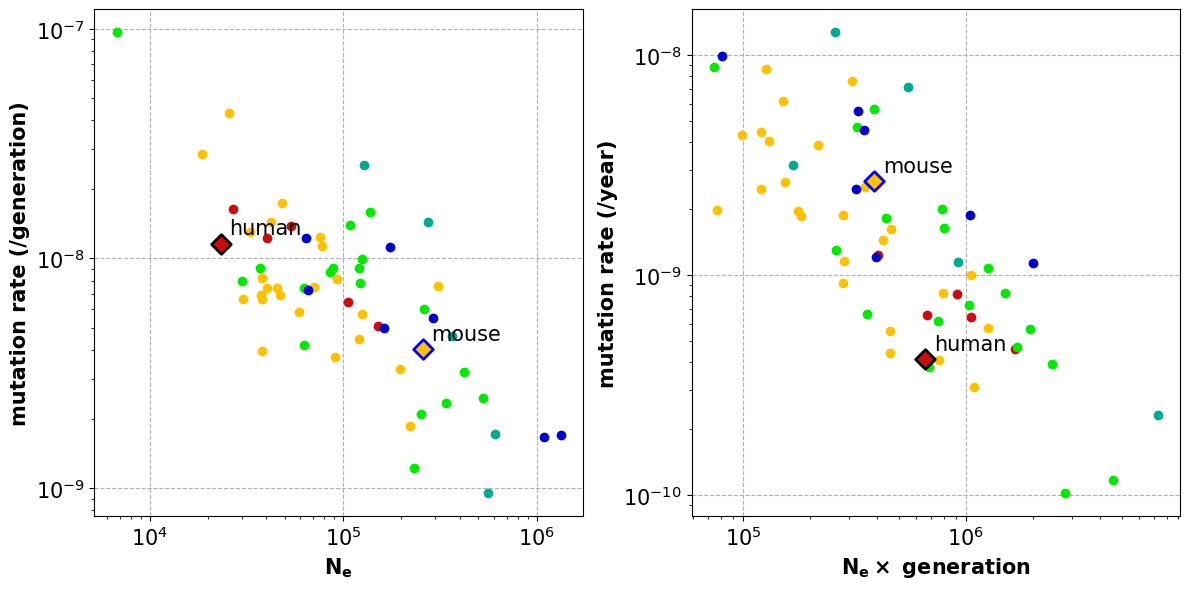

In [12]:
def generate_dbh_plot_overall_mutation_rate(df, group_name2idx_map):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    x1_label, y1_label = r"$\bf{N_e}$", "mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "Ne", "u_gen_non_modeled", x1_label, y1_label, ax=ax[0])
    x2_label, y2_label = r"$\bf{N_e} \times$ generation", "mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "Ne*g", "u_year_non_modeled", x2_label, y2_label, ax=ax[1])
generate_dbh_plot_overall_mutation_rate(df_div, vertebrate_group_name2idx_map)

## Regress mutation rate (total and CpG) on generation time g

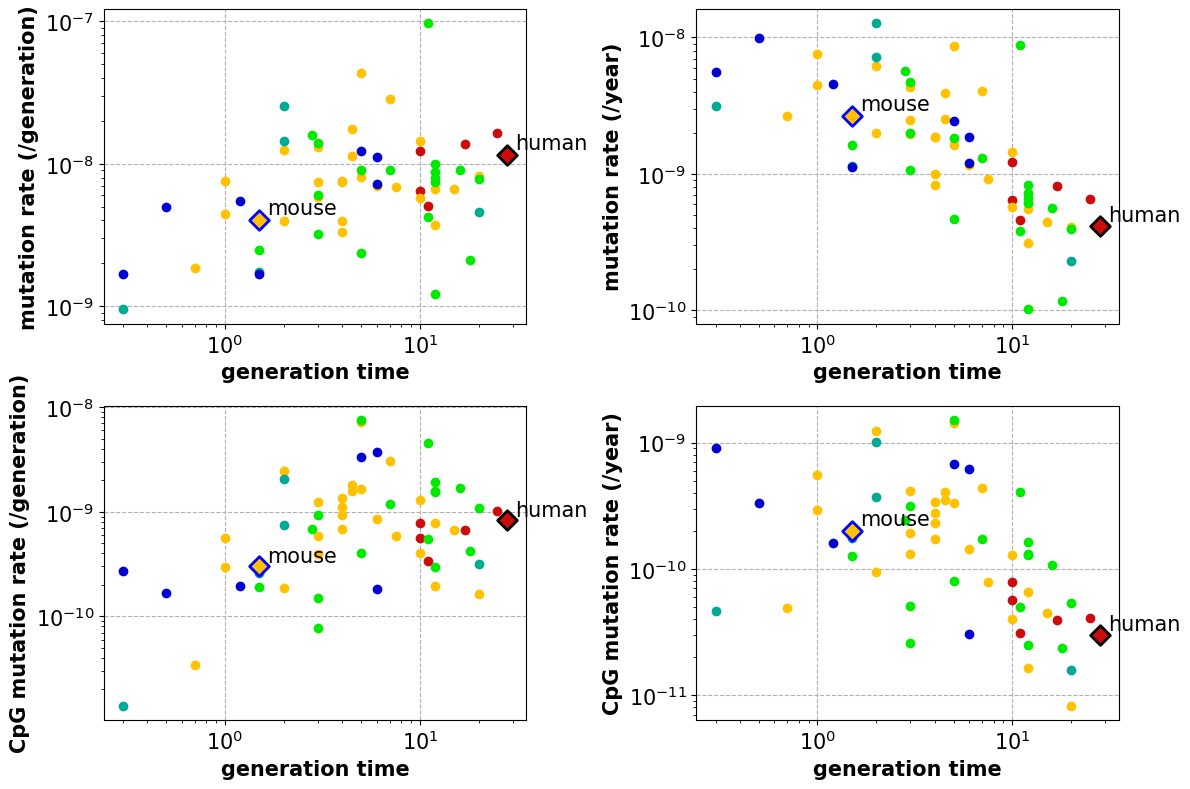

In [13]:
def generate_mu_vs_g_plots(df, group_name2idx_map):
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    x1_label, y1_label = "generation time", "mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_gen_non_modeled", x1_label, y1_label, ax=ax[0,0])
    x2_label, y2_label = "generation time", "mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_year_non_modeled", x2_label, y2_label, ax=ax[0,1])

    # CpG mutation rate
    x3_label, y3_label = "generation time", "CpG mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_CpG_gen_non_modeled", x3_label, y3_label, ax=ax[1,0])
    x4_label, y4_label = "generation time", "CpG mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_CpG_year_non_modeled", x4_label, y4_label, ax=ax[1,1])
    
generate_mu_vs_g_plots(df_div, vertebrate_group_name2idx_map)

### Only total yearly mutation rate vs generation time

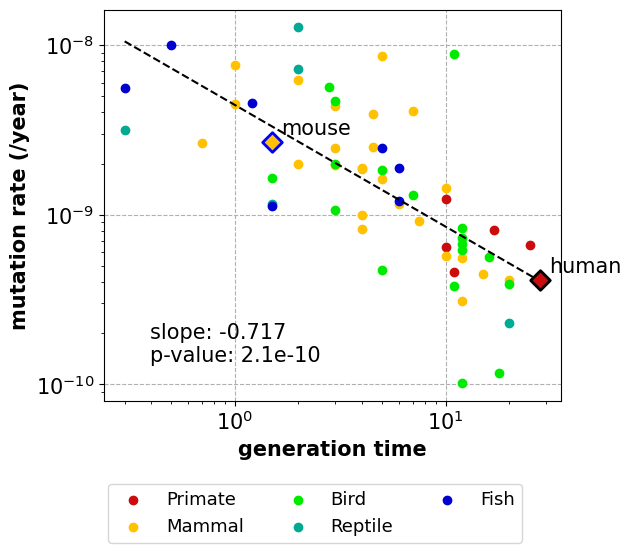

In [14]:
def load_and_plot_r_regression_output(r_filename, x_bounds, text_pos=(0.7, 0.85), ax=None):
    df = pd.read_csv(r_filename)
    intercept = df["intercept"].to_numpy()[0]
    slope = df["slope"].to_numpy()[0]
    p_val_slope = df["slope.p"].to_numpy()[0]
    plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=text_pos, p_value=p_val_slope, ax=ax)
    return [intercept, slope]
    
def plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    y = np.power(10, intercept) * np.power(x_bounds, slope)
    ax.plot(x_bounds, y, c="black", linestyle = 'dashed')
    if p_value:
        p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}"
        text = f"slope: {slope:.3f}\np-value: {p_val_str}"
    else:
        text = f"slope: {slope:.3f}"
    ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize)
    
def yearly_mutation_rate_gen_time(df, group_name2idx_map, save_figure=False):
    x_label, y_label = "generation time", "mutation rate (/year)"
    fig, ax = plt.subplots()
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_year_non_modeled", x_label, y_label, ax=ax)
    r_filename = f"./output/r_bergeron/mu_year_gen.csv"
    gen_time = df["gen_time"]
    x_bounds = [np.min(gen_time), np.max(gen_time)]
    load_and_plot_r_regression_output(r_filename, x_bounds, text_pos=(0.1, 0.1), ax=ax)
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=13, ncol=3)
    fig.tight_layout()
    if save_figure:
        fig.savefig("figures/yearly_mut_rate_vs_gen_time_bergeron.pdf", bbox_inches='tight')
    
yearly_mutation_rate_gen_time(df_div, vertebrate_group_name2idx_map)

## DBH plots for CpG mutation rate

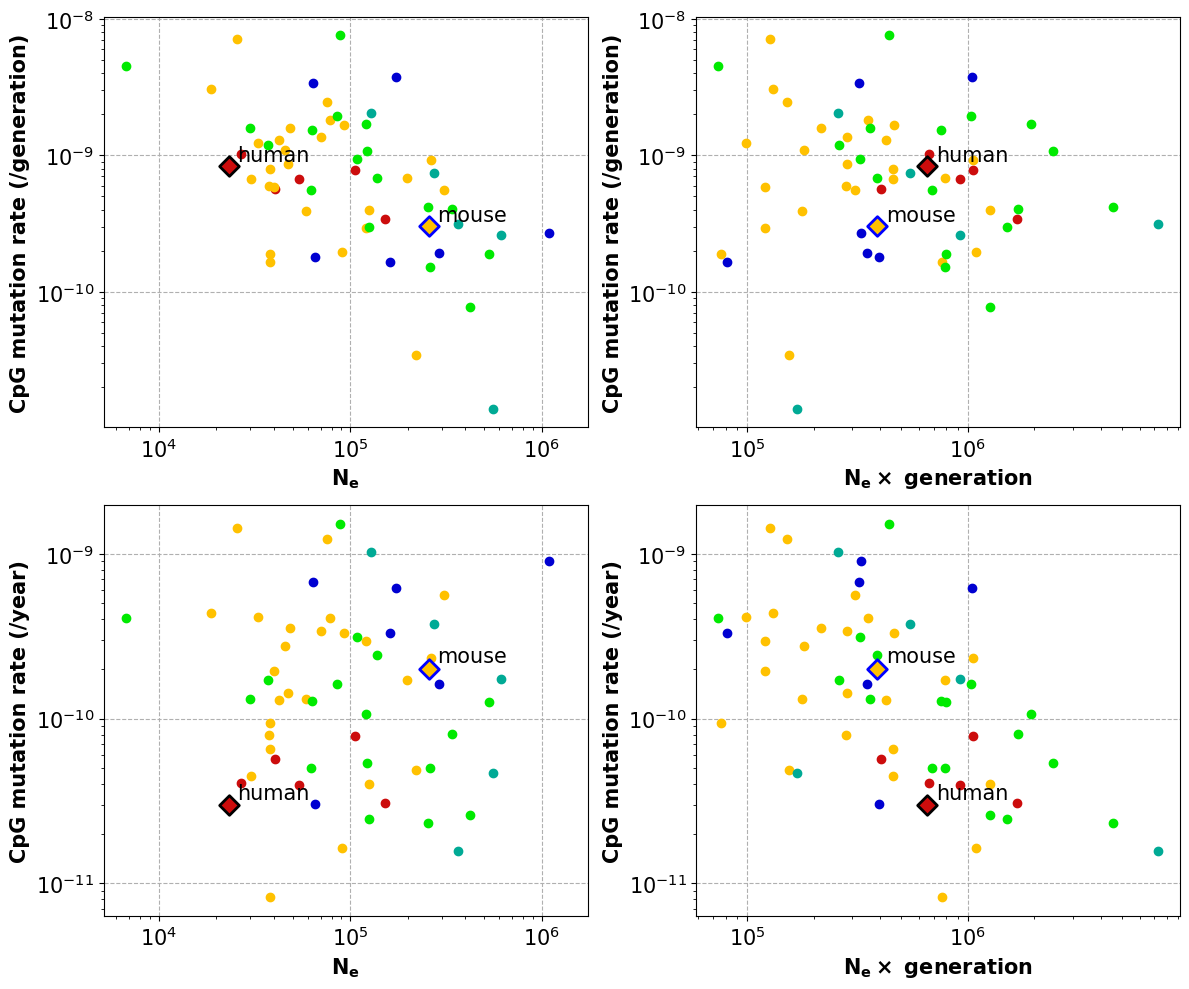

In [15]:
def generate_dbh_plot_CpG_mutation_rate(df, group_name2idx_map):
    fig, ax = plt.subplots(2, 2, figsize=(12,10))
    x1_label, y1_label = r"$\bf{N_e}$", "CpG mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "Ne", "u_CpG_gen_non_modeled", x1_label, y1_label, ax=ax[0,0])
    
    x2_label, y2_label = r"$\bf{N_e} \times$ generation", "CpG mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "Ne*g", "u_CpG_gen_non_modeled", x2_label, y2_label, ax=ax[0,1])
    
    x3_label, y3_label = r"$\bf{N_e}$", "CpG mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "Ne", "u_CpG_year_non_modeled", x3_label, y3_label, ax=ax[1,0])
    
    x4_label, y4_label = r"$\bf{N_e} \times$ generation", "CpG mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "Ne*g", "u_CpG_year_non_modeled", x4_label, y4_label, ax=ax[1,1])
generate_dbh_plot_CpG_mutation_rate(df_div, vertebrate_group_name2idx_map)